In [58]:
# Import the necessary packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

In [7]:
# Read the datasets
subject_data = pd.read_csv("subjectID_27.csv")
fatigue_data = pd.read_csv("fatiguePROs_subject_27.csv")

In [8]:
# Function to parse the timestamps of the wearable dataset in the proper date format
def parse_wearable_timestamp(ts):
    return datetime.strptime(ts, '%d.%m.%y %H:%M')

In [9]:
# Function to parse the timestamps of the fatigue dataset in the proper date format
def parse_fatigue_timestamp_adjusted(ts):
    try:
        return datetime.strptime(ts, '%d.%m.%y %H:%M')
    except ValueError:
        return datetime.strptime(ts, '%d.%m.%y')

In [10]:
# Apply the parsing to the datasets
subject_data['Timestamp'] = subject_data['Timestamp'].apply(parse_wearable_timestamp)
fatigue_data['Days'] = fatigue_data['Days'].apply(parse_fatigue_timestamp_adjusted)

In [11]:
# Create a date column for merging
subject_data['Date'] = subject_data['Timestamp'].dt.date
fatigue_data['Date'] = fatigue_data['Days'].dt.date

In [12]:
# Summarize each column by the median
wearable_daily_summary = subject_data.groupby('Date').agg({
    'ActivityCounts': 'median',
    'Barometer': 'median',
    'BloodPerfusion': 'median',
    'BloodPulseWave': 'median',
    'EnergyExpenditure': 'median',
    'GalvanicSkinResponse': 'median',
    'HR': 'median',
    'HRV': 'median',
    'RESP': 'median',
    'Steps': 'sum',  # Assuming sum is more appropriate for steps
    'SkinTemperature': 'median'
}).reset_index()

In [13]:
# Group the data by the mean for Question 1
# Describe fatigue on a scale of 1 to 10, where 1 means you don’t feel tired at all and 10 means the worst tiredness you can imagine
fatigue_daily_summary = fatigue_data.groupby('Date').agg({
    'Ans for Q1': 'mean'
}).reset_index()

In [14]:
# Merge the summaries on Date
daily_combined_summary = pd.merge(wearable_daily_summary, fatigue_daily_summary, on='Date', how='outer')

In [15]:
# Prepare the data for modeling
data_for_modeling = daily_combined_summary.dropna(subset=['Ans for Q1'])
X = data_for_modeling.drop(['Date', 'Ans for Q1'], axis=1)
y = data_for_modeling['Ans for Q1']

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Create a pipeline for imputation, scaling, and modeling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [18]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))])

In [19]:
# Extract and print feature importance
feature_importances = pipeline.named_steps['model'].feature_importances_
feature_importance_dict = dict(zip(X.columns, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

In [20]:
# Displaying the sorted feature importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.2f}")

HR: 0.24
Steps: 0.17
BloodPulseWave: 0.11
HRV: 0.10
Barometer: 0.10
EnergyExpenditure: 0.09
RESP: 0.06
SkinTemperature: 0.05
GalvanicSkinResponse: 0.04
BloodPerfusion: 0.03
ActivityCounts: 0.01


The Random Forest Regression model indicates that physiological measures related to heart function (HR and HRV), physical activity levels (Steps and Energy Expenditure), and environmental factors (Barometer) are among the most critical factors in assessing quality of life. These findings suggest an interplay between physical activity, cardiovascular health, and environmental conditions in determining overall well-being. It also highlights the potential for wearable device data to provide meaningful insights into health-related quality of life indicators.

In [21]:
features = ['HR', 'Steps', 'BloodPulseWave', 'HRV', 'EnergyExpenditure']

In [22]:
phrase_to_remove = "Describe fatigue on a scale of 1 to 10, where 1 means you don’t feel tired at all and 10 means the worst tiredness you can imagine"
filtered_fatigue_data = fatigue_data.loc[~fatigue_data['Question'].str.contains(phrase_to_remove, case=False, na=False)]
new_fatigue_data = filtered_fatigue_data.drop("Ans for Q1", axis=1)
new_fatigue_data

,Subject ID,Days,Timezone,Question,Ans for Q2-Q4,Date
1,27,2018-02-05 21:45:00,CET,"Are you feeling better, worse or the same as y...",Worse,2018-02-05
2,27,2018-02-05 21:45:00,CET,"Physically, today how often did you feel exhau...",Often,2018-02-05
3,27,2018-02-05 21:45:00,CET,"Mentally, today how often did you feel exhausted?",Regularly,2018-02-05
5,27,2018-02-06 21:45:00,CET,"Are you feeling better, worse or the same as y...",Same,2018-02-06
6,27,2018-02-06 21:45:00,CET,"Physically, today how often did you feel exhau...",Often,2018-02-06
...,...,...,...,...,...,...
246,27,2018-09-12 20:15:00,CEST,"Physically, today how often did you feel exhau...",Never,2018-09-12
247,27,2018-09-12 20:15:00,CEST,"Mentally, today how often did you feel exhausted?",Never,2018-09-12
249,27,2018-09-13 20:39:00,CEST,"Are you feeling better, worse or the same as y...",Same,2018-09-13
250,27,2018-09-13 20:39:00,CEST,"Physically, today how often did you feel exhau...",Never,2018-09-13


In [23]:
finished_fatigue_data = new_fatigue_data.set_index("Question", append=True).swaplevel().loc[new_fatigue_data["Question"].unique()].reset_index(level=0)

In [24]:
fatigue_data_q2 = finished_fatigue_data[finished_fatigue_data['Question'] == "Are you feeling better, worse or the same as yesterday?"]
fatigue_data_q3 = finished_fatigue_data[finished_fatigue_data['Question'] == "Physically, today how often did you feel exhausted?"]
fatigue_data_q4 = finished_fatigue_data[finished_fatigue_data['Question'] == "Mentally, today how often did you feel exhausted?"]

fatigue_data_q2 = fatigue_data_q2.reset_index(drop=True)
fatigue_data_q3 = fatigue_data_q3.reset_index(drop=True)
fatigue_data_q4 = fatigue_data_q4.reset_index(drop=True)

In [25]:
# Mappings for encoding
encoding_q2 = {'Worse': 0, 'Same': 1, 'Better': 2}
encoding_q3 = {'Never': 0, 'Sometimes': 1, 'Regularly': 2, 'Often': 3, 'Always': 4}
encoding_q4 = {'Never': 0, 'Sometimes': 1, 'Regularly': 2, 'Often': 3, 'Always': 4}

In [26]:
# Apply each encodings to the mapping
fatigue_data_q2['Ans_Encoded'] = fatigue_data_q2['Ans for Q2-Q4'].map(encoding_q2)
fatigue_data_q3['Ans_Encoded'] = fatigue_data_q3['Ans for Q2-Q4'].map(encoding_q3)
fatigue_data_q4['Ans_Encoded'] = fatigue_data_q4['Ans for Q2-Q4'].map(encoding_q4)

fatigue_data_q2 = fatigue_data_q2.drop("Days", axis=1)
fatigue_data_q3 = fatigue_data_q3.drop("Days", axis=1)
fatigue_data_q4 = fatigue_data_q4.drop("Days", axis=1)

In [27]:
# Data cleaning to prepare the data for the model
fatigue_data_q2_merged = pd.merge(fatigue_data_q2, wearable_daily_summary, on='Date', how='outer')
fatigue_data_q3_merged = pd.merge(fatigue_data_q3, wearable_daily_summary, on='Date', how='outer')
fatigue_data_q4_merged = pd.merge(fatigue_data_q4, wearable_daily_summary, on='Date', how='outer')

fatigue_data_q2_merged = fatigue_data_q2_merged.dropna(subset=['Ans_Encoded'])
fatigue_data_q3_merged = fatigue_data_q3_merged.dropna(subset=['Ans_Encoded'])
fatigue_data_q4_merged = fatigue_data_q4_merged.dropna(subset=['Ans_Encoded'])

In [28]:
# The 'Ans_Encoded' column is the target variable, and the rest are the features
X_q2 = fatigue_data_q2_merged[['HR', 'Steps', 'BloodPulseWave', 'HRV', 'EnergyExpenditure']]
y_q2 = fatigue_data_q2_merged['Ans_Encoded']

X_q3 = fatigue_data_q3_merged[['HR', 'Steps', 'BloodPulseWave', 'HRV', 'EnergyExpenditure']]
y_q3 = fatigue_data_q3_merged['Ans_Encoded']

X_q4 = fatigue_data_q4_merged[['HR', 'Steps', 'BloodPulseWave', 'HRV', 'EnergyExpenditure']]
y_q4 = fatigue_data_q4_merged['Ans_Encoded']

## Histogram-based Gradient Boosting Classification Tree
This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.

In [41]:
X_train_q2, X_test_q2, y_train_q2, y_test_q2 = train_test_split(X_q2, y_q2, test_size=0.2, random_state=42)

# Initialize and train the classifier
model2 = HistGradientBoostingClassifier()

# Fit the model
model2.fit(X_train_q2, y_train_q2)

# Make predictions
y_pred_q2 = model2.predict(X_test_q2)

# Evaluate the model
accuracy_q2 = accuracy_score(y_test_q2, y_pred_q2)
print(f"Accuracy: {accuracy_q2}")

Accuracy: 0.3076923076923077


This accuracy is relatively low, suggesting that the model struggles to predict the correct category for Question 2. This could be due to several reasons, such as the features not being strongly correlated with the outcomes of this question, or because the answers to Question 2 are more subjective and harder to predict based on objective measures.

In [42]:
X_train_q3, X_test_q3, y_train_q3, y_test_q3 = train_test_split(X_q3, y_q3, test_size=0.2, random_state=42)

# Initialize and train the classifier
model3 = HistGradientBoostingClassifier()

# Fit the model
model3.fit(X_train_q3, y_train_q3)

# Make predictions
y_pred_q3 = model3.predict(X_test_q3)

# Evaluate the model
accuracy_q3 = accuracy_score(y_test_q3, y_pred_q3)
print(f"Accuracy: {accuracy_q3}")

Accuracy: 0.7692307692307693


An accuracy of approximately 77% is substantially better than for Question 2, indicating that the features used in the model have a stronger relationship with the outcomes of Question 3. This might mean that the physical exhaustion levels (as Question 3 might inquire about) are more directly observable through the selected features like HR, Steps, etc. This is slightly better opposed to our previous result where the accuracy was 69%.

In [43]:
X_train_q4, X_test_q4, y_train_q4, y_test_q4 = train_test_split(X_q4, y_q4, test_size=0.2, random_state=42)

# Initialize and train the classifier
model4 = HistGradientBoostingClassifier()

# Fit the model
model4.fit(X_train_q4, y_train_q4)

# Make predictions
y_pred_q4 = model4.predict(X_test_q4)

# Evaluate the model
accuracy_q4 = accuracy_score(y_test_q4, y_pred_q4)
print(f"Accuracy: {accuracy_q4}")

Accuracy: 0.6153846153846154


This accuracy falls between the other two, suggesting a moderate level of prediction capability by the model for Question 4's outcomes. It implies that the model has some predictive power for this question but also highlights room for improvement. This is an increase from our previous 51%.

In [44]:
full_fatigue_data = fatigue_data_q2_merged.merge(fatigue_data_q3_merged, on='Date', how='inner', suffixes=('_q2', '_q3'))
full_fatigue_data = full_fatigue_data.merge(fatigue_data_q4_merged, on='Date', how='inner', suffixes=('', '_q4'))

X_full = full_fatigue_data[['HR', 'Steps', 'BloodPulseWave', 'HRV', 'EnergyExpenditure', 'Ans_Encoded_q3', 'Ans_Encoded']]
# 'Ans_Encoded' from Q4 might have to be renamed to avoid collision if not done in the merge step.

y_full = full_fatigue_data['Ans_Encoded_q2']  # Target variable from Q2

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

model_full = HistGradientBoostingClassifier()

# Fit the model
model_full.fit(X_train_full, y_train_full)

# Make predictions
y_pred_full = model_full.predict(X_test_full)

# Evaluate the model
accuracy_full = accuracy_score(y_test_full, y_pred_full)
print(f"Accuracy with data from Question 3 and Question 4: {accuracy_full}")

Accuracy with data from Question 3 and Question 4: 0.4


We can see the accuracy increased from 30% to 40%; however, this is still slightly underperforming compared to the predictions for Question 3 and Question 4.

In [33]:
# For Question 2
answer_distribution_q2 = fatigue_data_q2['Ans for Q2-Q4'].value_counts()

# For Question 3: Physically, today how often did you feel exhausted?
answer_distribution_q3 = fatigue_data_q3['Ans for Q2-Q4'].value_counts()

# For Question 4: Mentally, today how often did you feel exhausted?
answer_distribution_q4 = fatigue_data_q4['Ans for Q2-Q4'].value_counts()

# If you want to see the distribution as percentages of the total responses:
answer_distribution_q2_percentage = fatigue_data_q2['Ans for Q2-Q4'].value_counts(normalize=True) * 100
answer_distribution_q3_percentage = fatigue_data_q3['Ans for Q2-Q4'].value_counts(normalize=True) * 100
answer_distribution_q4_percentage = fatigue_data_q4['Ans for Q2-Q4'].value_counts(normalize=True) * 100

# Print the distributions
print("Distribution for Question 2:")
print(answer_distribution_q2)
print("\nAs percentages:")
print(answer_distribution_q2_percentage)

print("Distribution for Question 3 (Physical Exhaustion):")
print(answer_distribution_q3)
print("\nAs percentages:")
print(answer_distribution_q3_percentage)

print("\nDistribution for Question 4 (Mental Exhaustion):")
print(answer_distribution_q4)
print("\nAs percentages:")
print(answer_distribution_q4_percentage)

Distribution for Question 2:
Same      26
Better    20
Worse     17
Name: Ans for Q2-Q4, dtype: int64

As percentages:
Same      41.269841
Better    31.746032
Worse     26.984127
Name: Ans for Q2-Q4, dtype: float64
Distribution for Question 3 (Physical Exhaustion):
Sometimes    27
Never        21
Regularly     8
Often         6
Always        1
Name: Ans for Q2-Q4, dtype: int64

As percentages:
Sometimes    42.857143
Never        33.333333
Regularly    12.698413
Often         9.523810
Always        1.587302
Name: Ans for Q2-Q4, dtype: float64

Distribution for Question 4 (Mental Exhaustion):
Never        41
Sometimes    16
Regularly     5
Always        1
Name: Ans for Q2-Q4, dtype: int64

As percentages:
Never        65.079365
Sometimes    25.396825
Regularly     7.936508
Always        1.587302
Name: Ans for Q2-Q4, dtype: float64


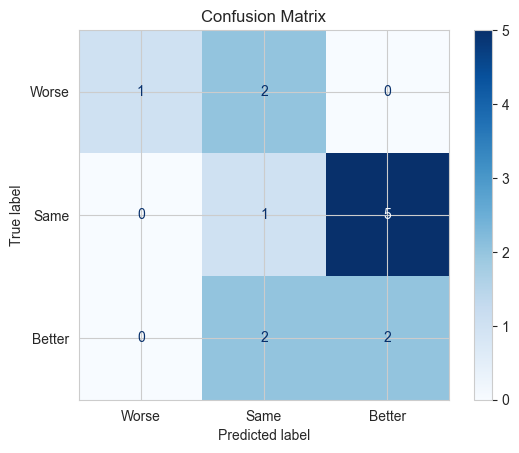

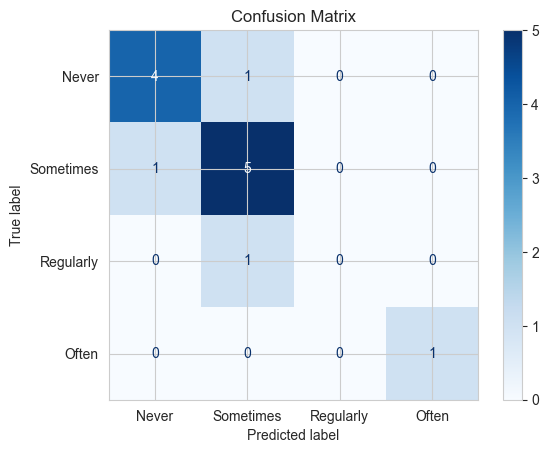

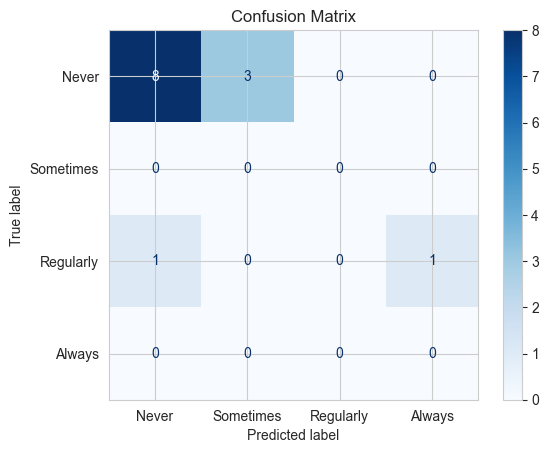

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test, labels):
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Example usage with custom labels
labels_q2 = ['Worse', 'Same', 'Better']
plot_confusion_matrix(model2, X_test_q2, y_test_q2, labels_q2)

labels_q3 = ['Never', 'Sometimes', 'Regularly', 'Often']
plot_confusion_matrix(model3, X_test_q3, y_test_q3, labels_q3)

labels_q4 = ['Never', 'Sometimes', 'Regularly', 'Always']
plot_confusion_matrix(model4, X_test_q4, y_test_q4, labels_q4)


From the confusion matrices, it is clear that for Question 2, the model predicts the subject is doing better, when in reality they are feeling the same. There was also the case where the model predicted the subject should be feeling the same, when the participant was actually feeling better or worse. This can be due to other factors that were not included in the fatiguePROs dataset that affected the subject. The confusion matrices for Questions 3 and 4 demonstrate the model performed much better, accurately predicting the mental and physical exhaustion. This is attributed to the fact that the model was fed objective data.

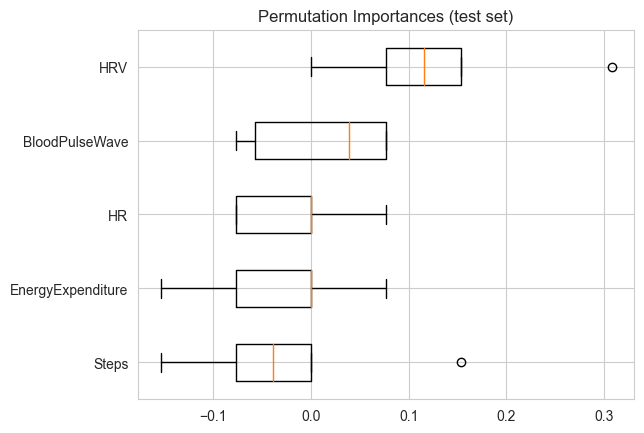

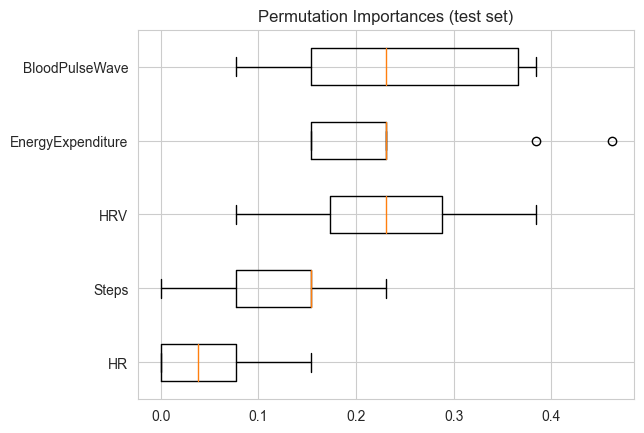

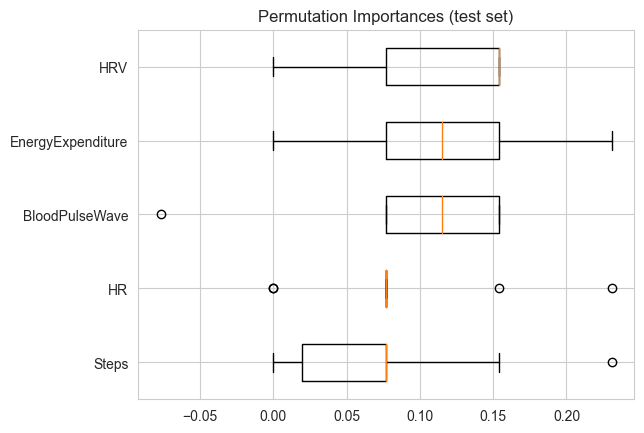

In [57]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def plot_permutation_importance(model, X_test, y_test, feature_names):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    plt.show()

# Question 2
plot_permutation_importance(model2, X_test_q2, y_test_q2, features)

# Question 3
plot_permutation_importance(model3, X_test_q3, y_test_q3, features)

# Question 4
plot_permutation_importance(model4, X_test_q4, y_test_q4, features)

Permutation Importance measures the decrease in model score when a single feature value is randomly shuffled. This process breaks the relationship between the feature and the target, thus the drop in model score provides a measure of how much the model depends on the feature.

For model 2:
- HRV (Heart Rate Variability): This feature appears to be the most important, with a median value that is positive and greater than the other features, and the interquartile range (IQR) does not overlap with zero. This suggests that HRV is a significant predictor in the model.
- BloodPulseWave: Has importance values mostly above zero, indicating relevance, but to a lesser extent than HRV.
- HR (Heart Rate) and Energy Expenditure: Have lower median importance values than HRV and BloodPulseWave. Their impact on the model is still positive, but they are less significant predictors.
- Steps: Shows importance values around zero and below, implying that this feature has the least influence on the model's predictions.

For model 3:
- BloodPulseWave: It stands out as the most influential feature for this model with a higher median importance and values largely above zero.
- Energy Expenditure: Also shows a positive impact on the model predictions, but with a broader range of values, indicating variability in its influence across different shuffles.
- HRV: Here, it appears to have less influence compared to its impact on Model 2, but it is still a significant predictor.
- Steps: This feature has a wide range of importance values, some of which overlap with zero, suggesting its predictive power is not consistent.
- HR: Shows the least impact on the model with importance values close to zero.

For model 4:
- HRV: Is the feature with the highest median importance and values above zero, similar to its prominence in Model 2, indicating a strong influence on the model's predictions.
- Energy Expenditure: Comes next with positive importance values, although its range suggests some variability in its impact.
- BloodPulseWave and HR: Have a lower median importance than HRV and Energy Expenditure, with HR showing some values that are less than zero.
- Steps: Similar to the other models, shows very low to negative importance, indicating it does not have a predictive impact on the model.

Overall conclusion:
- The relative importance of features varies across models, which could be due to differences in the underlying structure of the data or the nature of the questions being predicted.
- HRV is consistently one of the most important features across models, especially for Model 2 and Model 4, indicating its strong association with the target variable.
- BloodPulseWave is particularly influential in Model 3 but less so in the others.
- Steps appears to be the least useful predictor across all models, as indicated by its low or negative importance values.
- The wide ranges and outliers in the box plots suggest there may be significant variability in how the features impact model performance across different permutations, which might point to interactions between features that aren't being captured by individual importance scores.